## 1. MPElectroML: Analysis of Electrode Material Data

This notebook provides a walkthrough of analyzing data generated by the `MPElectroML` package. `MPElectroML` automates fetching electrode material data from the Materials Project, performing structural modifications (like substituting working ions), and calculating energies/forces using machine-learned interatomic potentials (MLIPs) via FAIRChem.

We will:
1.  Examine the accuracy of MLIP energies by comparing them against DFT energies from the Materials Project for original host structures.
2.  Inspect the magnitude of initial forces on MP-derived structures, which are expected to be minimized.
3.  Merge datasets derived from different primary working ions (Li and Na) to find common charge hosts and compare substituted structures against MP DFT data.
4.  Create a combined dataset for further analysis.
5.  Calculate average "voltages" (binding energies of ion insertion) using the MLIP-computed energies.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core import Structure, Composition

LI_DATA_H5_PATH = "Li_electrodes_uma_m/Li_electrode_data_with_energies.h5"
NA_DATA_H5_PATH = "Na_electrodes_uma_m/Na_electrode_data_with_energies.h5"

E_LI_BULK_PER_ATOM = -2.377
E_NA_BULK_PER_ATOM = -3.548

In [93]:
# --- Helper Functions ---
def plot_energy_comparison(df, mp_energy_col, mlip_init_energy_col, mlip_relaxed_energy_col, title_prefix,
                           xlim=(None,None), ylim=(None,None)):
    """Plots MP energy vs. MLIP initial and relaxed energies."""
    plt.figure(figsize=(12, 5))

    # MP vs MLIP Initial
    plt.subplot(1, 2, 1)
    valid_data_init = df[[mp_energy_col, mlip_init_energy_col]].dropna()
    if not valid_data_init.empty:
        sns.scatterplot(data=valid_data_init, x=mp_energy_col, y=mlip_init_energy_col, alpha=0.7)
        min_val_init = min(valid_data_init[mp_energy_col].min(), valid_data_init[mlip_init_energy_col].min())
        max_val_init = max(valid_data_init[mp_energy_col].max(), valid_data_init[mlip_init_energy_col].max())
        plt.plot([min_val_init, max_val_init], [min_val_init, max_val_init], 'k--', lw=2, label="Ideal Match")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(f"{title_prefix}: MP vs. MLIP Initial Energy")
        plt.xlabel("MP Energy per Atom (eV/atom)")
        plt.ylabel("MLIP Initial Energy per Atom (eV/atom)")
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "No data for Initial Energy plot", ha='center', va='center')
        plt.title(f"{title_prefix}: MP vs. MLIP Initial Energy (No Data)")


    # MP vs MLIP Relaxed
    plt.subplot(1, 2, 2)
    valid_data_relaxed = df[[mp_energy_col, mlip_relaxed_energy_col]].dropna()
    if not valid_data_relaxed.empty:
        sns.scatterplot(data=valid_data_relaxed, x=mp_energy_col, y=mlip_relaxed_energy_col, alpha=0.7)
        min_val_relaxed = min(valid_data_relaxed[mp_energy_col].min(), valid_data_relaxed[mlip_relaxed_energy_col].min())
        max_val_relaxed = max(valid_data_relaxed[mp_energy_col].max(), valid_data_relaxed[mlip_relaxed_energy_col].max())
        plt.plot([min_val_relaxed, max_val_relaxed], [min_val_relaxed, max_val_relaxed], 'k--', lw=2, label="Ideal Match")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(f"{title_prefix}: MP vs. MLIP Relaxed Energy")
        plt.xlabel("MP Energy per Atom (eV/atom)")
        plt.ylabel("MLIP Relaxed Energy per Atom (eV/atom)")
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "No data for Relaxed Energy plot", ha='center', va='center')
        plt.title(f"{title_prefix}: MP vs. MLIP Relaxed Energy (No Data)")

    plt.tight_layout()
    plt.show()


def plot_forces_histogram(df, forces_col, title, bins=100):
    """Plots a histogram of the magnitudes of initial forces."""
    forces_data = df[forces_col].dropna()
    if not forces_data.empty:
        # Calculate magnitude of each force vector, then average magnitude per structure
        avg_force_magnitudes = forces_data.apply(lambda forces_array: np.max(np.linalg.norm(forces_array, axis=1))
                                                 if forces_array is not None and forces_array.ndim == 2 else np.nan).dropna()
        if not avg_force_magnitudes.empty:
            plt.figure(figsize=(8, 5))
            sns.histplot(avg_force_magnitudes, bins=bins)
            plt.title(title)
            plt.xlabel("Max Force Magnitudes (eV/Å)")
            # plt.xscale('log')
            plt.xlim(0, 2)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
        else:
            print(f"No valid force magnitudes to plot for: {title}")
            plt.figure(figsize=(8,5))
            plt.text(0.5, 0.5, "No valid force magnitudes to plot", ha='center', va='center')
            plt.title(title)
            plt.show()
    else:
        print(f"No force data to plot for: {title}")
        plt.figure(figsize=(8,5))
        plt.text(0.5, 0.5, "No force data to plot", ha='center', va='center')
        plt.title(title)
        plt.show()


def get_num_atoms(structure):
    """Safely gets the number of atoms in a Pymatgen structure."""
    if isinstance(structure, Structure):
        return len(structure)
    return 0  # Or np.nan, depending on how you want to handle missing structures


def get_composition(structure):
    """Safely gets the composition of a Pymatgen structure."""
    if isinstance(structure, Structure):
        return structure.composition
    return None

Let's start by loading the two primary datasets you've generated: one where Li-ion electrodes were fetched and Na was substituted, and another where Na-ion electrodes were fetched and Li was substituted.

In [94]:
# Load the HDF5 files (adjust key if necessary based on MPElectroML.utils constants)
# The key used in add_energy_forces_to_df is "data_with_energies" or HDF5_KEY_WITH_ENERGIES
HDF5_KEY = "electrode_data_with_energies" # As defined in mpelectroml.utils.HDF5_KEY_WITH_ENERGIES

try:
    df_li_raw = pd.read_hdf(LI_DATA_H5_PATH)#, key=HDF5_KEY)
    print(f"Successfully loaded Lithium dataset from: {LI_DATA_H5_PATH}")
    print(f"Lithium DataFrame shape: {df_li_raw.shape}")
    print(f"Lithium DataFrame columns: {df_li_raw.columns.tolist()}")
except Exception as e:
    print(f"Error loading Lithium dataset from {LI_DATA_H5_PATH}: {e}")
    df_li_raw = pd.DataFrame()

try:
    df_na_raw = pd.read_hdf(NA_DATA_H5_PATH)#, key=HDF5_KEY)
    print(f"Successfully loaded Sodium dataset from: {NA_DATA_H5_PATH}")
    print(f"Sodium DataFrame shape: {df_na_raw.shape}")
    print(f"Sodium DataFrame columns: {df_na_raw.columns.tolist()}")
except Exception as e:
    print(f"Error loading Sodium dataset from {NA_DATA_H5_PATH}: {e}")
    df_na_raw = pd.DataFrame()

Successfully loaded Lithium dataset from: Li_ion_electrodes/Li_electrode_data_with_energies.h5
Lithium DataFrame shape: (2434, 25)
Lithium DataFrame columns: ['charge_id', 'discharge_id', 'charge_structure', 'charge_formula', 'charge_energy_per_atom', 'discharge_structure', 'discharge_formula', 'discharge_energy_per_atom', 'Na_discharge_structure', 'Na_discharge_formula', 'Na_discharge_init_energy_per_atom', 'Na_discharge_init_forces', 'Na_discharge_relaxed_structure', 'Na_discharge_relaxed_energy_per_atom', 'Na_discharge_relaxed_forces', 'charge_init_energy_per_atom', 'charge_init_forces', 'charge_relaxed_structure', 'charge_relaxed_energy_per_atom', 'charge_relaxed_forces', 'discharge_init_energy_per_atom', 'discharge_init_forces', 'discharge_relaxed_structure', 'discharge_relaxed_energy_per_atom', 'discharge_relaxed_forces']
Successfully loaded Sodium dataset from: Na_ion_electrodes/Na_electrode_data_with_energies.h5
Sodium DataFrame shape: (314, 25)
Sodium DataFrame columns: ['char

### 1.1. Analysis of the Lithium-Primary Dataset (`df_li`)

This dataset was generated by querying the Materials Project for Lithium-ion electrode materials. Subsequently, Sodium (`Na`) was substituted as a new working ion into these Li-ion host structures.

#### 1.1.1. Initial Forces Histogram for Li-Dataset
Structures obtained from the Materials Project are typically DFT-relaxed. Therefore, the initial forces calculated by the MLIP on these unmodified structures should ideally be small. We plot histograms of the average force magnitude per atom.

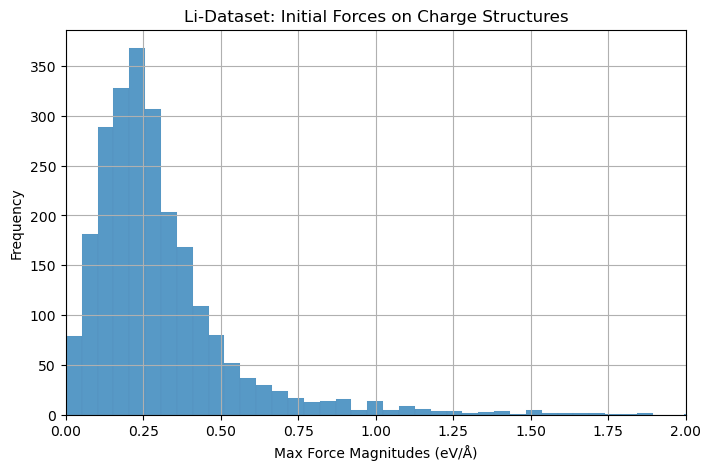

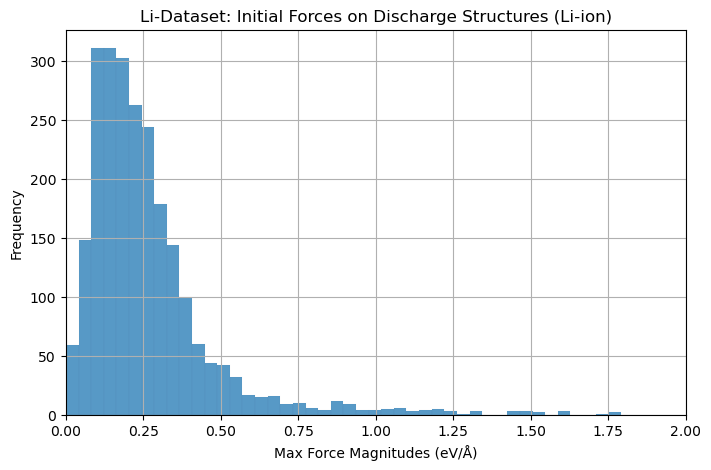

In [95]:
plot_forces_histogram(df_li_raw, 'charge_init_forces', 'Li-Dataset: Initial Forces on Charge Structures', bins=4000)
plot_forces_histogram(df_li_raw, 'discharge_init_forces', 'Li-Dataset: Initial Forces on Discharge Structures (Li-ion)', bins=4000)

#### 1.1.2. Energy Comparison for Li-Dataset (Charge Structures)
We compare the DFT energy per atom from Materials Project (`charge_energy_per_atom`) with the MLIP-calculated initial (`charge_init_energy_per_atom`) and relaxed (`charge_relaxed_energy_per_atom`) energies for the **charge** (delithiated/host) structures.

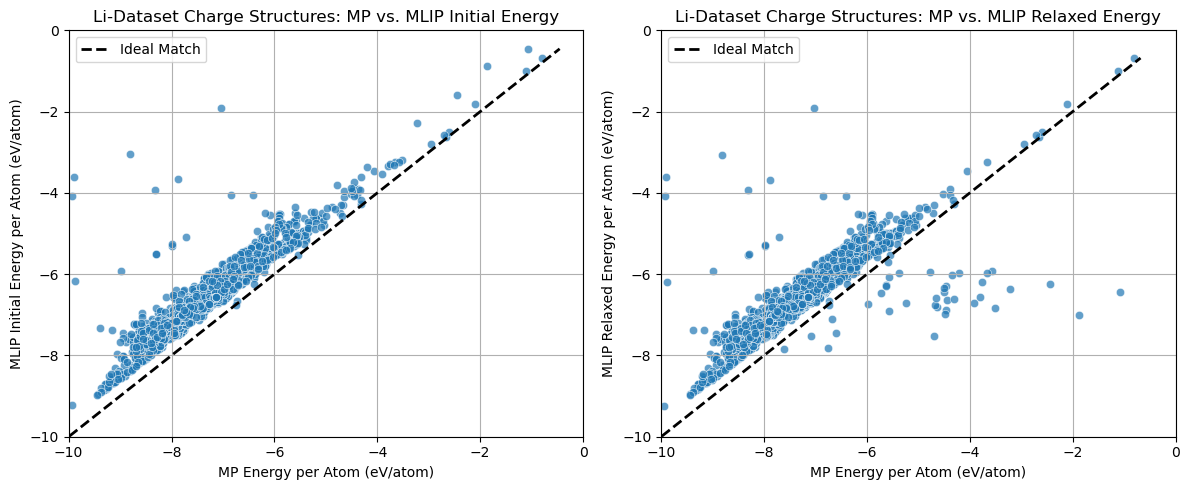

In [96]:
plot_energy_comparison(df_li_raw,
                        'charge_energy_per_atom',
                        'charge_init_energy_per_atom',
                        'charge_relaxed_energy_per_atom',
                        'Li-Dataset Charge Structures',
                        xlim=(-10, 0), ylim=(-10, 0))

#### 1.1.3. Energy Comparison for Li-Dataset (Discharge Structures - Original Li-ion)
Similarly, for the **discharge** (lithiated) structures, we compare MP DFT energies (`discharge_energy_per_atom`) with MLIP initial (`discharge_init_energy_per_atom`) and relaxed (`discharge_relaxed_energy_per_atom`) energies.


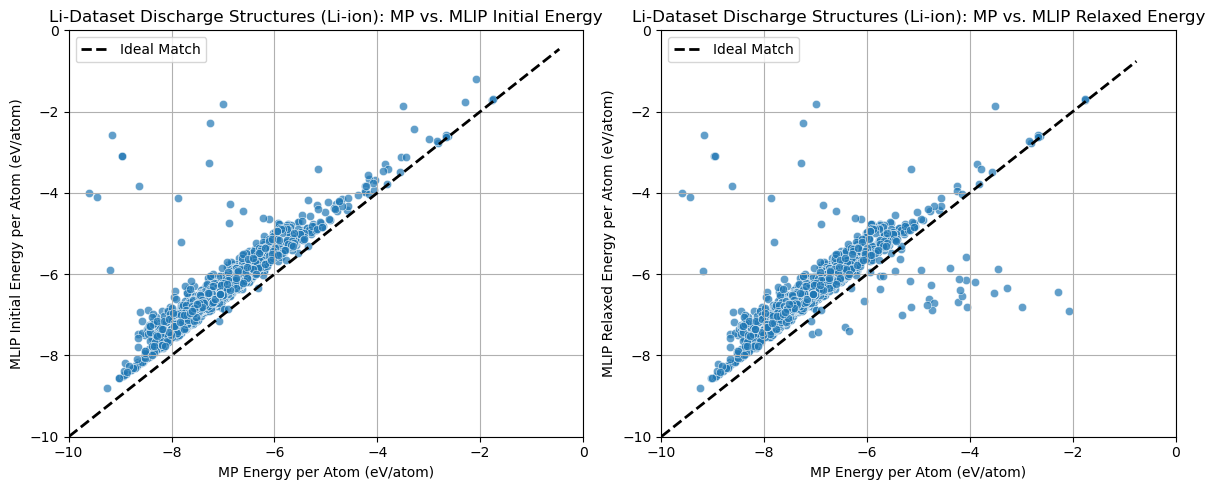

In [97]:
plot_energy_comparison(df_li_raw,
                        'discharge_energy_per_atom', # This is MP energy for original Li-discharge
                        'discharge_init_energy_per_atom',
                        'discharge_relaxed_energy_per_atom',
                        'Li-Dataset Discharge Structures (Li-ion)',
                        xlim=(-10, 0), ylim=(-10, 0))

### 1.2. Analysis of the Sodium-Primary Dataset (`df_na`)

This dataset was generated by querying the Materials Project for Sodium-ion electrode materials. Lithium (`Li`) was then substituted as a new working ion.

#### 1.2.1. Initial Forces Histogram for Na-Dataset

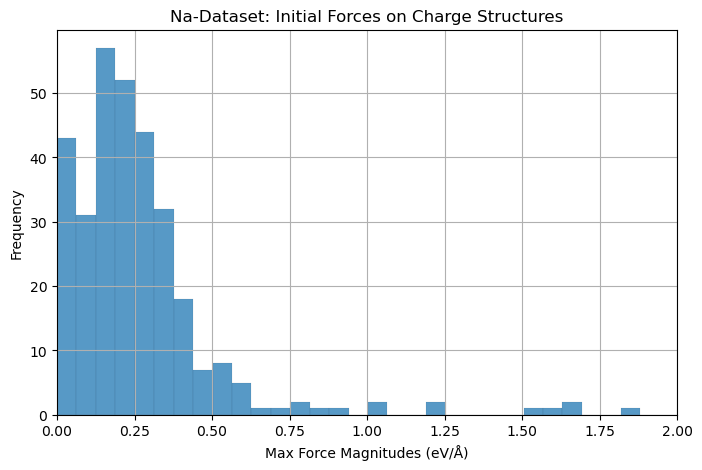

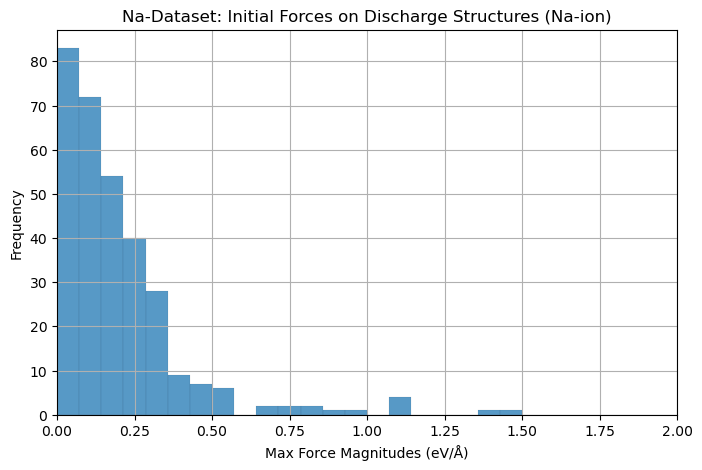

In [98]:
plot_forces_histogram(df_na_raw, 'charge_init_forces', 'Na-Dataset: Initial Forces on Charge Structures', bins=1000)
plot_forces_histogram(df_na_raw, 'discharge_init_forces', 'Na-Dataset: Initial Forces on Discharge Structures (Na-ion)', bins=1000)

#### 1.2.2. Energy Comparison for Na-Dataset (Charge Structures)

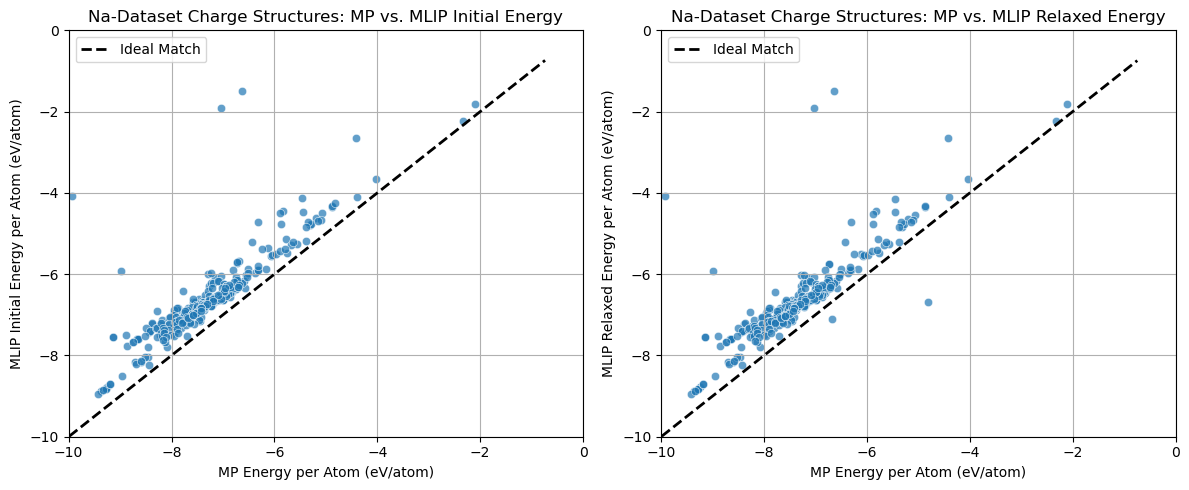

In [99]:
plot_energy_comparison(df_na_raw,
                        'charge_energy_per_atom',
                        'charge_init_energy_per_atom',
                        'charge_relaxed_energy_per_atom',
                        'Na-Dataset Charge Structures',
                        xlim=(-10, 0), ylim=(-10, 0))

#### 1.2.2. Energy Comparison for Na-Dataset (Discharge Structures - Original Na-ion)

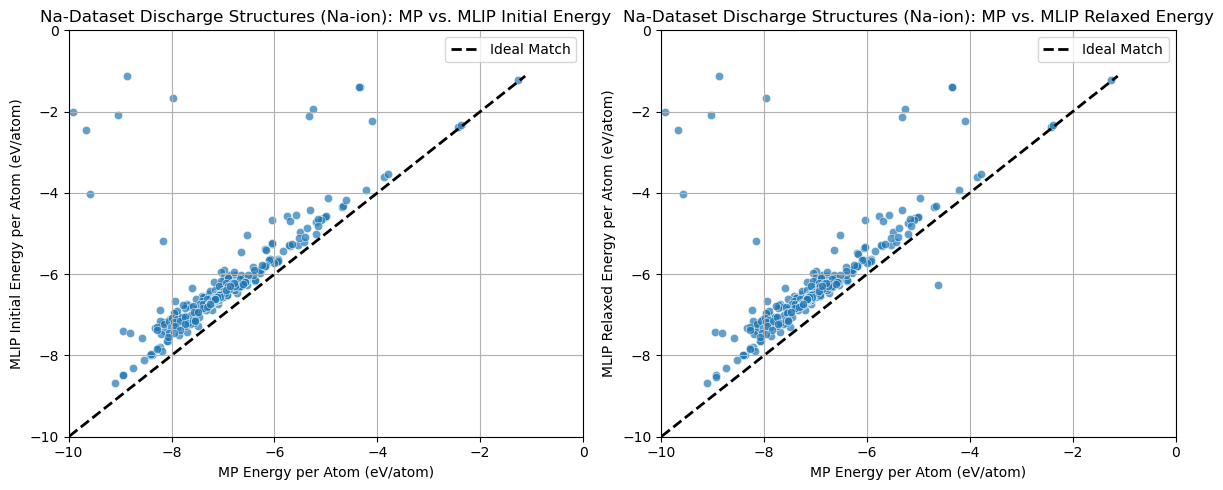

In [100]:
plot_energy_comparison(df_na_raw,
                        'discharge_energy_per_atom', # This is MP energy for original Na-discharge
                        'discharge_init_energy_per_atom',
                        'discharge_relaxed_energy_per_atom',
                        'Na-Dataset Discharge Structures (Na-ion)',
                        xlim=(-10, 0), ylim=(-10, 0))

### Interpretation of Part 1 & 2:

* **Energy Plots**: The scatter plots help visualize the MLIP's accuracy. Ideally, points should lie on the y=x line. Deviations indicate discrepancies between DFT (MP) and MLIP energies. Relaxed MLIP energies might show better correlation if the MLIP force field is good and the initial MP structures were not perfectly relaxed under the MLIP's potential.
* **Force Histograms**: These histograms show the distribution of residual forces on MP structures when evaluated by the MLIP. Small forces suggest that the MP structures are also low-energy configurations according to the MLIP. Large forces might indicate that the MLIP prefers a different local minimum.

These plots are crucial for validating whether the chosen MLIP is suitable for the chemical systems under study.

## 2. Merging Datasets and Cross-Validating Substituted Ions

Now, we'll merge the two datasets based on common `charge_id` values. This is interesting because:
* A `charge_id` (host material) that appears in both `df_li` and `df_na` means this host was identified as both a Li-ion and Na-ion electrode host by the Materials Project.
* For such common hosts:
    * The Na-discharge structure synthesized in `df_li` (by substituting Li with Na) can be compared against the "true" Na-discharge structure found in `df_na` from MP.
    * Similarly, the Li-discharge structure synthesized in `df_na` (by substituting Na with Li) can be compared against the "true" Li-discharge structure found in `df_li` from MP.

This cross-comparison is a powerful way to assess how well the structural substitution and subsequent MLIP relaxation predict actual discharged structures and energies for a *different* working ion.

We need to select relevant columns and rename them for clarity before merging.
Columns for df_li:
- charge_id
- charge_energy_per_atom (MP)
- discharge_energy_per_atom (MP energy for Li-discharge)
- Na_discharge_init_energy_per_atom (MLIP for synthetic Na-discharge)
- Na_discharge_relaxed_energy_per_atom (MLIP for synthetic Na-discharge)

Columns for df_na:
- charge_id
- charge_energy_per_atom (MP)
- discharge_energy_per_atom (MP energy for Na-discharge)
- Li_discharge_init_energy_per_atom (MLIP for synthetic Li-discharge)
- Li_discharge_relaxed_energy_per_atom (MLIP for synthetic Li-discharge)

In [101]:
df_li_compare = df_li_raw[['charge_id', 'discharge_energy_per_atom', # MP for Li-discharge
                            'Na_discharge_init_energy_per_atom',
                            'Na_discharge_relaxed_energy_per_atom']].copy()
df_li_compare.rename(columns={'discharge_energy_per_atom': 'mp_Li_discharge_energy_per_atom'}, inplace=True)

df_na_compare = df_na_raw[['charge_id', 'discharge_energy_per_atom', # MP for Na-discharge
                            'Li_discharge_init_energy_per_atom',
                            'Li_discharge_relaxed_energy_per_atom']].copy()
df_na_compare.rename(columns={'discharge_energy_per_atom': 'mp_Na_discharge_energy_per_atom'}, inplace=True)

# Merge based on common charge_id
df_merged_compare = pd.merge(df_li_compare, df_na_compare, on='charge_id', how='inner')
print(f"\nFound {len(df_merged_compare)} common charge_ids for cross-comparison.")


Found 124 common charge_ids for cross-comparison.


### 2.1. Compare Synthetic Na-discharge (from Li-dataset) with MP Na-discharge
Here, `mp_Na_discharge_energy_per_atom` is the DFT energy of the Na-discharged structure from the Materials Project (via `df_na`).
`Na_discharge_init_energy_per_atom` and `Na_discharge_relaxed_energy_per_atom` are MLIP energies for the Na-discharged
structure that was *created by substituting Li with Na* in the Li-dataset's host.

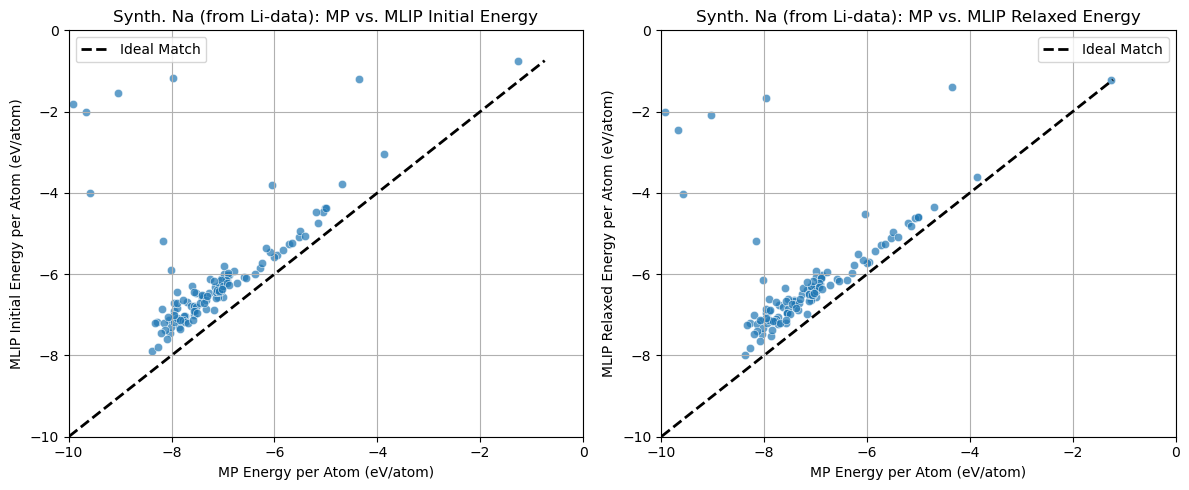

In [102]:
plot_energy_comparison(df_merged_compare,
                        'mp_Na_discharge_energy_per_atom',
                        'Na_discharge_init_energy_per_atom', # Synthetic Na from Li-dataset
                        'Na_discharge_relaxed_energy_per_atom', # Synthetic Na from Li-dataset
                        'Synth. Na (from Li-data)',
                        xlim=(-10, 0), ylim=(-10, 0))

### 2.2. Compare Synthetic Li-discharge (from Na-dataset) with MP Li-discharge
Analogous to the above, but for Li.

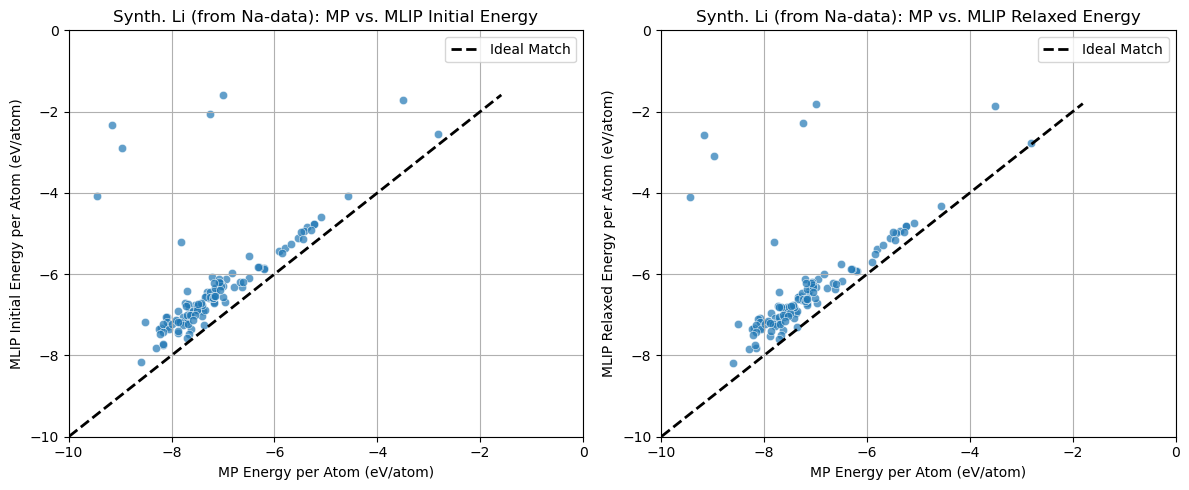

In [103]:
plot_energy_comparison(df_merged_compare,
                        'mp_Li_discharge_energy_per_atom',
                        'Li_discharge_init_energy_per_atom', # Synthetic Li from Na-dataset
                        'Li_discharge_relaxed_energy_per_atom', # Synthetic Li from Na-dataset
                        'Synth. Li (from Na-data)',
                        xlim=(-10, 0), ylim=(-10, 0))

## 3. Creating a Unified Third DataFrame (`df3`)

We'll now create a third DataFrame (`df3`) that consolidates information from `df_li_raw` and `df_na_raw`.
The goal is to have a single entry per `charge_id`, with dedicated columns for Li-discharge and Na-discharge properties, using MLIP energies.

**Columns for `df3`**:
* `charge_id`
* `charge_structure` (MLIP relaxed structure)
* `charge_energy_per_atom` (MLIP relaxed energy)
* `li_discharge_id`
* `li_discharge_structure` (MLIP relaxed)
* `li_discharge_energy_per_atom` (MLIP relaxed)
* `na_discharge_id`
* `na_discharge_structure` (MLIP relaxed)
* `na_discharge_energy_per_atom` (MLIP relaxed)

**Logic for `df3` construction**:
1.  Perform an outer merge of selected columns from `df_li_raw` and `df_na_raw` on `charge_id`.
2.  For `charge` properties, use data from `df_li_raw` if available, else from `df_na_raw`.
3.  For `li_discharge` properties:
    * If the `charge_id` was in `df_li_raw` (i.e., it's an original Li-ion electrode), use its Li-discharge data.
    * If the `charge_id` was *only* in `df_na_raw`, use the *synthesized* Li-discharge data from `df_na_raw` (i.e., `Li_discharge_relaxed_structure` and its energy).
4.  For `na_discharge` properties:
    * If the `charge_id` was in `df_na_raw` (i.e., it's an original Na-ion electrode), use its Na-discharge data.
    * If the `charge_id` was *only* in `df_li_raw`, use the *synthesized* Na-discharge data from `df_li_raw` (i.e., `Na_discharge_relaxed_structure` and its energy).

In [104]:
df3 = pd.DataFrame()

# Select and rename columns for df_li_raw
df_li_sel = df_li_raw[[
    'charge_id',
    'charge_structure', 'charge_energy_per_atom',  # DFT relaxed (from MP)
    'charge_relaxed_structure', 'charge_relaxed_energy_per_atom',  # MLIP relaxed
    'discharge_structure', 'discharge_energy_per_atom',  # DFT relaxed (from MP)
    'discharge_id', 'discharge_relaxed_structure', 'discharge_relaxed_energy_per_atom',  # Original Li-discharge
    'Na_discharge_relaxed_structure', 'Na_discharge_relaxed_energy_per_atom'  # Synthesized Na-discharge
]].copy()
df_li_sel.rename(columns={
    'charge_structure': 'DFT_charge_structure_li',
    'charge_energy_per_atom': 'DFT_charge_energy_li',
    'charge_relaxed_structure': 'MLIP_charge_structure_li',
    'charge_relaxed_energy_per_atom': 'MLIP_charge_energy_li',
    'discharge_structure': 'DFT_li_discharge_structure_li',
    'discharge_energy_per_atom': 'DFT_li_discharge_energy_li',
    'discharge_id': 'li_discharge_id_li',
    'discharge_relaxed_structure': 'MLIP_li_discharge_structure_li',
    'discharge_relaxed_energy_per_atom': 'MLIP_li_discharge_energy_li',
    'Na_discharge_relaxed_structure': 'MLIP_na_discharge_structure_li',
    'Na_discharge_relaxed_energy_per_atom': 'MLIP_na_discharge_energy_li'
}, inplace=True)

# Select and rename columns for df_na_raw
df_na_sel = df_na_raw[[
    'charge_id',
    'charge_structure', 'charge_energy_per_atom',  # DFT relaxed (from MP)
    'charge_relaxed_structure', 'charge_relaxed_energy_per_atom',  # MLIP relaxed
    'discharge_structure', 'discharge_energy_per_atom',  # DFT relaxed (from MP)
    'discharge_id', 'discharge_relaxed_structure', 'discharge_relaxed_energy_per_atom',  # Original Na-discharge
    'Li_discharge_relaxed_structure', 'Li_discharge_relaxed_energy_per_atom'  # Synthesized Li-discharge
]].copy()
df_na_sel.rename(columns={
    'charge_structure': 'DFT_charge_structure_na',
    'charge_energy_per_atom': 'DFT_charge_energy_na',
    'charge_relaxed_structure': 'MLIP_charge_structure_na',
    'charge_relaxed_energy_per_atom': 'MLIP_charge_energy_na',
    'discharge_structure': 'DFT_na_discharge_structure_na',
    'discharge_energy_per_atom': 'DFT_na_discharge_energy_na',
    'discharge_id': 'na_discharge_id_na',
    'discharge_relaxed_structure': 'MLIP_na_discharge_structure_na',
    'discharge_relaxed_energy_per_atom': 'MLIP_na_discharge_energy_na',
    'Li_discharge_relaxed_structure': 'MLIP_li_discharge_structure_na',
    'Li_discharge_relaxed_energy_per_atom': 'MLIP_li_discharge_energy_na'
}, inplace=True)

# Outer merge
df_merged_outer = pd.merge(df_li_sel, df_na_sel, on='charge_id', how='outer')

# Populate df3
df3['charge_id'] = df_merged_outer['charge_id']
df3['DFT_charge_structure'] = df_merged_outer['DFT_charge_structure_li'].combine_first(df_merged_outer['DFT_charge_structure_na'])
df3['DFT_charge_energy_per_atom'] = df_merged_outer['DFT_charge_energy_li'].combine_first(df_merged_outer['DFT_charge_energy_na'])
df3['MLIP_charge_structure'] = df_merged_outer['MLIP_charge_structure_li'].combine_first(df_merged_outer['MLIP_charge_structure_na'])
df3['MLIP_charge_energy_per_atom'] = df_merged_outer['MLIP_charge_energy_li'].combine_first(df_merged_outer['MLIP_charge_energy_na'])

# Li-discharge properties
df3['li_discharge_id'] = df_merged_outer['li_discharge_id_li']
df3['DFT_li_discharge_structure'] = df_merged_outer['DFT_li_discharge_structure_li']
df3['DFT_li_discharge_energy_per_atom'] = df_merged_outer['DFT_li_discharge_energy_li']
df3['MLIP_li_discharge_structure'] = df_merged_outer['MLIP_li_discharge_structure_li'].combine_first(
    df_merged_outer['MLIP_li_discharge_structure_na'])
df3['MLIP_li_discharge_energy_per_atom'] = df_merged_outer['MLIP_li_discharge_energy_li'].combine_first(
    df_merged_outer['MLIP_li_discharge_energy_na'])

# Na-discharge properties
df3['na_discharge_id'] = df_merged_outer['na_discharge_id_na']
df3['DFT_na_discharge_structure'] = df_merged_outer['DFT_na_discharge_structure_na']
df3['DFT_na_discharge_energy_per_atom'] = df_merged_outer['DFT_na_discharge_energy_na']
df3['MLIP_na_discharge_structure'] = df_merged_outer['MLIP_na_discharge_structure_na'].combine_first(
    df_merged_outer['MLIP_na_discharge_structure_li'])
df3['MLIP_na_discharge_energy_per_atom'] = df_merged_outer['MLIP_na_discharge_energy_na'].combine_first(
    df_merged_outer['MLIP_na_discharge_energy_li'])

# # Drop rows where crucial structure information might be missing for voltage calculation
# df3.dropna(subset=['charge_structure', 'charge_energy_per_atom'], inplace=True)
# # For Li voltage, we need Li-discharge info; for Na voltage, Na-discharge info
# # We will handle NaNs during the calculation itself.

print(f"\nCreated df3 with shape: {df3.shape}")
print(f"df3 columns: {df3.columns.tolist()}")
print(df3.head())


Created df3 with shape: (2624, 15)
df3 columns: ['charge_id', 'DFT_charge_structure', 'DFT_charge_energy_per_atom', 'MLIP_charge_structure', 'MLIP_charge_energy_per_atom', 'li_discharge_id', 'DFT_li_discharge_structure', 'DFT_li_discharge_energy_per_atom', 'MLIP_li_discharge_structure', 'MLIP_li_discharge_energy_per_atom', 'na_discharge_id', 'DFT_na_discharge_structure', 'DFT_na_discharge_energy_per_atom', 'MLIP_na_discharge_structure', 'MLIP_na_discharge_energy_per_atom']
  charge_id                               DFT_charge_structure  \
0     mp-23                                    [[0. 0. 0.] Ni]   
1     mp-28                                    [[0. 0. 0.] Ce]   
2     mp-45                                    [[0. 0. 0.] Ca]   
3     mp-80  [[-1.67726612e-06  1.93674134e+00  1.36754016e...   
4    mp-102                                    [[0. 0. 0.] Co]   

   DFT_charge_energy_per_atom  \
0                  -11.981717   
1                  -30.840629   
2                   -7.03

## 4. Calculating Average "Voltage"

We will calculate the binding energy of ion insertion per ion, which you referred to as "voltage".
The formula used is:
`BindingEnergy_X = (E_X_discharged_total - E_charged_total_scaled - n_X_added * E_X_bulk_per_atom) / n_X_added`
Where:
* `E_X_discharged_total` is the total MLIP energy of the (Li/Na)-discharged structure.
* `E_charged_total_scaled` is the total MLIP energy of the charged (host) structure, scaled to match the number of host atoms in the discharged structure.
* `n_X_added` is the number of X (Li/Na) atoms added to the scaled charged structure to form the discharged structure.
* `E_X_bulk_per_atom` is the energy per atom of bulk X (Li/Na).

A more negative binding energy indicates a more favorable insertion.
Typical electrochemical voltage is `V = -BindingEnergy_X / (n_X_added * e_charge)`, but we'll stick to your definition.

In [105]:
def calculate_binding_energy(df_row, working_ion_symbol, bulk_energy_per_atom, PES='MLIP'):

    charged_struct = df_row[PES+'_charge_structure']
    charged_energy_pa = df_row[PES+'_charge_energy_per_atom']
    if working_ion_symbol == 'Li':
        discharged_struct = df_row[PES+'_li_discharge_structure']
        discharged_energy_pa = df_row[PES+'_li_discharge_energy_per_atom']
    elif working_ion_symbol == 'Na':
        discharged_struct = df_row[PES+'_na_discharge_structure']
        discharged_energy_pa = df_row[PES+'_na_discharge_energy_per_atom']
    else:
        return np.nan

    # Ensure all necessary components are present
    if not all(isinstance(s, Structure) for s in [charged_struct, discharged_struct]) or \
       pd.isna(charged_energy_pa) or pd.isna(discharged_energy_pa):
        return np.nan

    # Get compositions and remove working ion to find host compositions
    comp_charged = charged_struct.composition
    comp_discharged = discharged_struct.composition

    # Create host compositions by attempting to remove all potential working ions
    # to handle cases where the "charged" structure might still contain some working ions.
    host_elements_charged = [el for el in comp_charged.elements if el.symbol not in ['Li', 'Na']]
    host_comp_charged_dict = {el: comp_charged.get_atomic_fraction(el) * len(charged_struct)
                              for el in host_elements_charged}
    # Number of atoms in the host part of the charged structure
    num_host_atoms_charged = sum(host_comp_charged_dict.values())


    host_elements_discharged = [el for el in comp_discharged.elements if el.symbol not in ['Li', 'Na']]
    host_comp_discharged_dict = {el: comp_discharged.get_atomic_fraction(el) * len(discharged_struct)
                                 for el in host_elements_discharged}
    # Number of atoms in the host part of the discharged structure
    num_host_atoms_discharged = sum(host_comp_discharged_dict.values())

    # Scaling factor to make the amount of host material in charged_struct equal to that in discharged_struct
    scaling_factor = num_host_atoms_discharged / num_host_atoms_charged

    # Calculate total energies
    e_charged_total_unscaled = charged_energy_pa * len(charged_struct)
    e_charged_total_scaled = e_charged_total_unscaled * scaling_factor

    e_discharged_total = discharged_energy_pa * len(discharged_struct)

    # Calculate number of working ions
    n_ion_charged_unscaled = comp_charged.get_el_amt_dict().get(working_ion_symbol, 0)
    n_ion_charged_scaled = n_ion_charged_unscaled * scaling_factor
    n_ion_discharged = comp_discharged.get_el_amt_dict().get(working_ion_symbol, 0)

    delta_n_ion = n_ion_discharged - n_ion_charged_scaled

    assert abs(len(discharged_struct) - scaling_factor*len(charged_struct) - delta_n_ion) < 0.00001, \
        f"Mismatch in atom counts: {len(discharged_struct)} - {scaling_factor*len(charged_struct)} - {delta_n_ion} != 0"

    if delta_n_ion <= 0: # No ions inserted, or ions removed
        return np.nan

    binding_energy = (e_discharged_total - e_charged_total_scaled - (delta_n_ion * bulk_energy_per_atom)) / delta_n_ion
    return binding_energy


Binding energies (eV) calculated in df3:
  charge_id  DFT_li_voltage  DFT_na_voltage  MLIP_li_voltage  MLIP_na_voltage
0     mp-23             NaN        0.539491         0.594813         2.784403
1     mp-28        0.435139        0.603017         0.919854         2.831711
2     mp-45        0.052523        0.097566         0.531497         2.331369
3     mp-80       -1.109301       -0.872361        -0.464029         1.565202
4    mp-102             NaN        0.865817         0.897670         3.056198


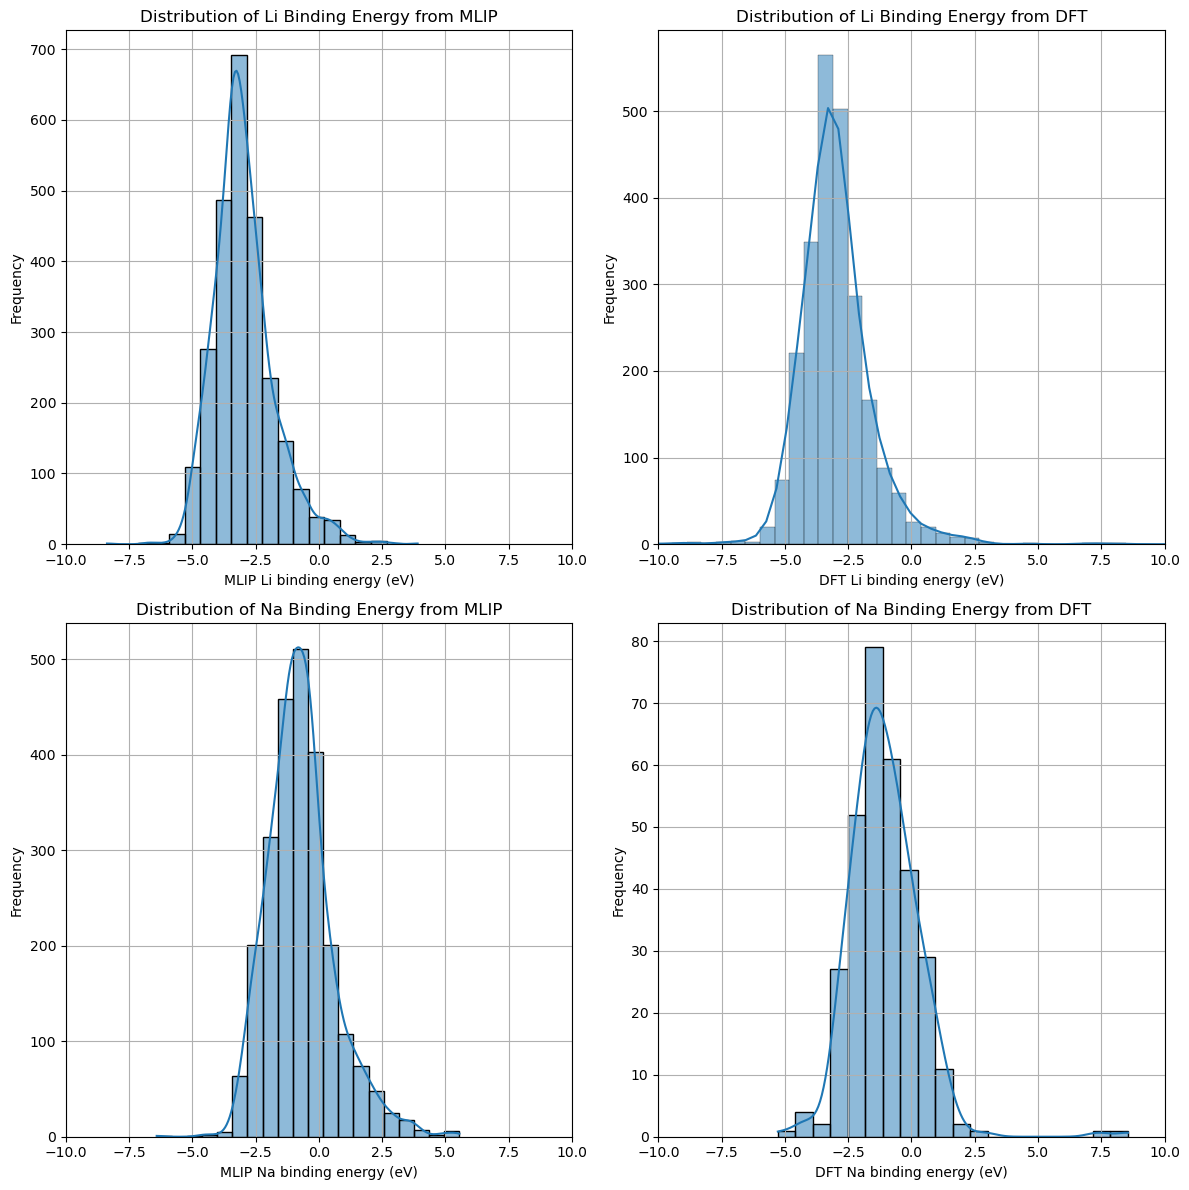

In [106]:
df3['MLIP_li_voltage'] = df3.apply(lambda row: calculate_binding_energy(row, 'Li', E_LI_BULK_PER_ATOM, PES='MLIP'), axis=1)
df3['MLIP_na_voltage'] = df3.apply(lambda row: calculate_binding_energy(row, 'Na', E_NA_BULK_PER_ATOM, PES='MLIP'), axis=1)
df3['DFT_li_voltage'] = df3.apply(lambda row: calculate_binding_energy(row, 'Li', E_LI_BULK_PER_ATOM, PES='DFT'), axis=1)
df3['DFT_na_voltage'] = df3.apply(lambda row: calculate_binding_energy(row, 'Na', E_NA_BULK_PER_ATOM, PES='DFT'), axis=1)

print("\nBinding energies (eV) calculated in df3:")
print(df3[['charge_id', 'DFT_li_voltage', 'DFT_na_voltage', 'MLIP_li_voltage', 'MLIP_na_voltage']].head())

# Plot histograms of these binding energies
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
sns.histplot(df3['MLIP_li_voltage'].dropna(), kde=True, bins=20)
plt.title('Distribution of Li Binding Energy from MLIP')
plt.xlabel('MLIP Li binding energy (eV)')
plt.ylabel('Frequency')
plt.xlim(-10, 10)  # Adjust xlim for better visibility
plt.grid(True)

plt.subplot(2, 2, 2)
sns.histplot(df3['DFT_li_voltage'].dropna(), kde=True, bins=140)
plt.title('Distribution of Li Binding Energy from DFT')
plt.xlabel('DFT Li binding energy (eV)')
plt.ylabel('Frequency')
plt.xlim(-10, 10)  # Adjust xlim for better visibility
plt.grid(True)

plt.subplot(2, 2, 3)
sns.histplot(df3['MLIP_na_voltage'].dropna(), kde=True, bins=20)
plt.title('Distribution of Na Binding Energy from MLIP')
plt.xlabel('MLIP Na binding energy (eV)')
plt.ylabel('Frequency')
plt.xlim(-10, 10)  # Adjust xlim for better visibility
plt.grid(True)

plt.subplot(2, 2, 4)
sns.histplot(df3['DFT_na_voltage'].dropna(), kde=True, bins=20)
plt.title('Distribution of Na Binding Energy from DFT')
plt.xlabel('DFT Na binding energy (eV)')
plt.ylabel('Frequency')
plt.xlim(-10, 10)  # Adjust xlim for better visibility
plt.grid(True)

plt.tight_layout()
plt.show()

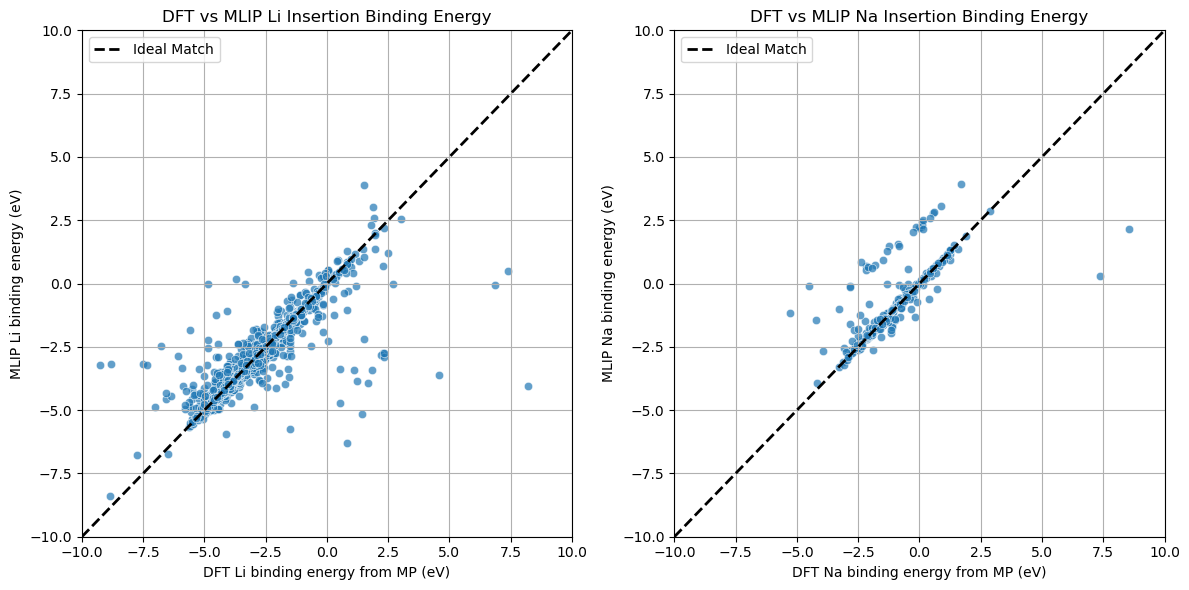

In [107]:
# Plot pairwise relationhsip between DFT and MLIP binding energies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df3, x='DFT_li_voltage', y='MLIP_li_voltage', alpha=0.7)
plt.title('DFT vs MLIP Li Insertion Binding Energy')
plt.xlabel('DFT Li binding energy from MP (eV)')
plt.ylabel('MLIP Li binding energy (eV)')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.plot([-10, 10], [-10, 10], 'k--', lw=2, label="Ideal Match")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df3, x='DFT_na_voltage', y='MLIP_na_voltage', alpha=0.7)
plt.title('DFT vs MLIP Na Insertion Binding Energy')
plt.xlabel('DFT Na binding energy from MP (eV)')
plt.ylabel('MLIP Na binding energy (eV)')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.plot([-10, 10], [-10, 10], 'k--', lw=2, label="Ideal Match")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Potential Uses of the Data and Further Analysis:

1.  **Screening Candidate Materials**:
    * The calculated binding energies (`li_binding_energy`, `na_binding_energy`) can be used to rank candidate electrode materials. Lower (more negative) binding energies are generally preferred for cathode materials (when defined as insertion).
    * Materials with promising binding energies can be selected for more computationally expensive DFT calculations or experimental validation.

2.  **Understanding MLIP Performance**:
    * The pairwise energy plots (MP vs. MLIP) provide direct insight into the MLIP's accuracy for the specific chemical space of your electrode materials.
    * If the MLIP shows large deviations for certain structural types or compositions, it might indicate limitations of the potential for those cases.

3.  **Structural Analysis**:
    * The `charge_structure`, `li_discharge_structure`, and `na_discharge_structure` columns (containing Pymatgen Structure objects) allow for detailed structural analysis. You can:
        * Calculate volume changes upon ion insertion/removal.
        * Analyze bond lengths, coordination environments.
        * Study diffusion pathways (though this requires further calculations like NEB).

4.  **Dataset for Further Machine Learning**:
    * The `df3` DataFrame, enriched with MLIP energies and structures, can serve as a dataset for training custom machine learning models. For example, you could train models to predict binding energies or other properties directly from structural features.

5.  **Investigating Discrepancies**:
    * Entries where MLIP energies significantly differ from MP DFT energies, or where synthesized structures are very different from MP experimental/DFT structures, warrant closer inspection. This can help identify:
        * Challenging cases for the MLIP.
        * Possible errors in the MP data or the substitution process.
        * Novel structural transformations predicted by the MLIP.

This notebook provides a starting point. Depending on your research goals, you can extend this analysis considerably.